In [ ]:
from tensorflow.keras.layers import Input,Conv2D ,MaxPooling2D,concatenate,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Model

def conv_block(x,n_filters):
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)*
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  return x


def encoder_block(x,n_filters):
  x=conv_block(x,n_filters)
  p=MaxPooling2D((2,2))(x)
  return x, p

def decoder_block(x,p,n_filters):
  x=Conv2DTranspose(n_filters,(2,2),strides=(2,2),padding='same')(x)
  x=concatenate([x,p])
  x=conv_block(x,n_filters)
  return x

def unet_model(n_classes,img_height,img_width,img_channels):
  inputs=Input((img_height,img_width,img_channels))

  #Contraction path,encoder
  c1,p1=encoder_block(inputs,n_filters=64)
  c2,p2=encoder_block(c1,n_filters=128)
  c3,p3=encoder_block(c2,n_filters=256)
  c4,p4=encoder_block(c3,n_filters=512)

  #Bottleneck
  bridge=conv_block(p4,n_filters=1024)

  #Expansive path,decoder
  u4=decoder_block(bridge,p4,n_filters=512)
  u3=decoder_block(u4,p3,n_filters=256)
  u2=decoder_block(u3,p2,n_filters=128)
  u1=decoder_block(u2,p1,n_filters=64)

  outputs=Conv2D(n_classes,(1,1),activation='softmax')(ul)
  model=Model(inputs=[inputs],outputs=[outputs])
  return model

unet_model=multi_unet_model(
    n_classes=5,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    img_channels=3
)




In [ ]:
model.compile(
    loss="categorical_crossentropy",
    categorical_crossentropy
)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds
    epochs=10,
)

# SEGMENTATION

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print("User uploaded file '{name}' with length {length} bytes".format(
      name=fn,length=len(uploaded[fn])
  ))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file 'kaggle.json' with length 71 bytes


In [3]:
!kaggle competitions list

ref                                                                                deadline             category                reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2      2025-04-01 23:59:00  Featured         2,117,152 Usd         45           False  
https://www.kaggle.com/competitions/arc-prize-2024                                 2024-11-10 23:59:00  Featured         1,100,000 Usd       1193           False  
https://www.kaggle.com/competitions/gemma-language-tuning                          2025-01-15 00:59:00  Analytics          150,000 Usd          0           False  
https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting  2025-01-13 23:59:00  Featured           120,000 Usd        299           False  
https://www.kagg

In [4]:
!kaggle datasets download "tschandl/isic2018-challenge-task1-data-segmentation"

Dataset URL: https://www.kaggle.com/datasets/tschandl/isic2018-challenge-task1-data-segmentation
License(s): CC0-1.0
100% 12.8G/12.9G [02:34<00:00, 112MB/s]
100% 12.9G/12.9G [02:34<00:00, 89.3MB/s]


In [5]:
!unzip isic2018-challenge-task1-data-segmentation.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000345.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000346.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000348.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000349.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000350.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000351.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000352.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000353.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000354.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000355.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000357.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000358.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000359.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000360.jpg  
  inflating: ISIC2018_Task

In [7]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tdfs
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D ,MaxPooling2D ,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout ,Activation


In [8]:
seed=42
tf.random.set_seed(seed)


In [ ]:
#Processing
IMG_HEIGHT=512
IMG_WIDTH=1024
BATCH_SIZE=8

val_split=0.2
n_classes=5
class_names=[]


In [10]:
def parse_image_and_mask(image_path,mask_path):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image,[IMG_HEIGHT,IMG_WIDTH])
  image=tf.cast(image,tf.int64)


  mask=tf.io_read_file(mask_path)
  mask=tf.image.decode_png(mask,channels=1)
  mask=tf.image.resize(mask,[IMG_HEIGHT,IMG_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask=tf.one_hot(tf.cast(mask,tf.int32),depth=n_classes)
  mask=tf.squeeze(mask,-2)
  return image,mask

def create_dataset(image_paths,mask_paths):
  path_dataset=tf.data.Dataset.from_tensor_slices((image_paths,mask_paths))
  dataset=path_dataset.map(parse_image_and_mask,num_parallel_calls=tf.dataAUTOTUNE)
  return dataset

root="kagle/input/path"
#image_paths=sorted(glob(os.path.join(root,"images/*")))
#mask_paths=sorted(glob(os.path.join(root,"masks/*")))
image_paths="/content/ISIC2018_Task1-2_Training_Input"
mask_paths="/content/ISIC2018_Task1_Training_GroundTruth"
dataset=create_dataset(image_paths,mask_paths)



ValueError: Unbatching a tensor is only supported for rank >= 1

In [11]:
def plot_examples(image,mask,pred=None):
  plt.figure(figsize=(20,10))
  ncols=n_classes
  nrows=2 if pred is None else 3

  plt.subplot(nrows,ncols,1)
  plt.imshow(image)
  plt.title("Image")
  plt.axis("off")

  for i in range(n_classes):
    mask_channel=mask[:,:,1]
    plt.subplot(nrows,ncols,i+n_classes+1)
    plt.imshow(mask_channel)
    plt.title(f"Mask, {class_names[i]}")
    plt.axis("off")

  if pred is not None :
    for i in range(n_classes):
      mask_channeld=pred[:,:,i]
      plt.subplot(nrows,ncols,i+n_classes*2+1)
      plt.imshow(mask_channel)
      plt.title(f"Prediction, {class_names[i]}")
      plt.axis("off")

  plt.tight_layout()
  plt.show()


In [7]:
image,mask=next(iter(dataset))

plot_examples(image,mask)

NameError: name 'dataset' is not defined

In [9]:
import os
import tensorflow as tf


train_image_path="/content/ISIC2018_Task1-2_Training_Input"
train_mask_path="/content/ISIC2018_Task1_Training_GroundTruth"

test_image_path="/content/ISIC2018_Task1-2_Test_Input"


def normalize(input_image,input_mask=None):
  input_image=tf.cast(input_image,tf.float32)/255.0
  if input_mask is not None:
    input_mask=tf.cast(input_mask,tf.float32)/255.0
  return input_image,input_mask

def load_train_image(image_path,mask_path):
  input_image=tf.io.read_file(image_path)
  input_image=tf.image.decode_jpeg(input_image,channels=3)
  input_image=tf.image.resize(input_image,(128,128))

  input_mask=tf.io.read_file(mask_path)
  input_mask=tf.image.decode_png(input_mask,channels=1)
  input_mask=tf.image.resize(input_mask,(128,128),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image,input_mask=normalize(input_image,input_mask)
  return input_image, input_mask

def load_test_image(image_path):
  input_image=tf.io.read_file(image_path)
  input_image=tf.image.decode_jpeg(input_image,channels=3)
  input_image=tf.image.resize(input_image,(128,128))
  input_image,_=normalize(input_image)
  return input_image

def load_train_data(train_image_repertory,mask_repertory):
  train_images_paths=sorted([os.path.join(train_image_repertory,fname) for fname in os.listdir(train_image_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  print("train_image_paths :",len(train_images_paths))
  masks_paths=sorted([os.path.join(mask_repertory,fname) for fname in os.listdir(mask_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  print("mask_paths :",len(masks_paths))
  assert len(train_images_paths)==len(masks_paths) ,'Number of images and mask should be the same .'
  dataset=tf.data.Dataset.from_tensor_slices((train_images_paths,masks_paths))
  dataset=dataset.map(load_train_image,num_parallel_calls=tf.data.AUTOTUNE)
  return dataset

def load_test_data(test_image_repertory):
  test_images_paths=sorted([os.path.join(test_image_repertory,fname) for fname in os.listdir(test_image_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  dataset=tf.data.Dataset.from_tensor_slices(test_images_paths)
  dataset=dataset.map(load_test_image,num_parallel_calls=tf.data.AUTOTUNE)
  return dataset

In [10]:
train_dataset=load_train_data(train_image_path,train_mask_path)

test_dataset=load_test_data(test_image_path)

BATCH_SIZE=64
BUFFER_SIZE = 1000

train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


train_image_paths : 2594
mask_paths : 2594


In [11]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed=42):
    super().__init__()
    self.augment_inputs=tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal",seed=seed),
                         tf.keras.layers.RandomRotation(factor=0.1,seed=seed),
                         tf.keras.layers.RandomZoom(height_factor=0.1,seed=seed)
                         ])
    self.augment_labels=tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal",seed=seed),

                                             tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,seed=seed
                                                                        )])
  def call(self,inputs,labels):
    inputs=self.augment_inputs(inputs)
    labels=self.augment_labels(labels)
    return inputs,labels


In [12]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title=["Input Image","True Mask","Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")

  plt.show()

In [41]:
train_dataset=load_train_data(train_image_path,train_mask_path)

test_dataset=load_test_data(test_image_path)

BATCH_SIZE=64
BUFFER_SIZE=1000

augment_layer=Augment()

train_batches=(
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
"""
test_batches=(
    test_dataset
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)"""

train_image_paths : 2594
mask_paths : 2594


'\ntest_batches=(\n    test_dataset\n    .batch(BATCH_SIZE)\n    .prefetch(buffer_size=tf.data.AUTOTUNE)\n)'

In [42]:
SEED=42
tf.random.set_seed(SEED)
total_size=len(train_dataset)
train_size=int(0.7*total_size)
valid_size=int(0.15*total_size)
test_size=int(0.15*total_size)


train_batches=train_batches.take(train_size)
val_batches=train_batches.skip(train_size).take(valid_size)
test_batches=train_batches.skip(train_size + valid_size)
"""
val_batches=(
    val_batches
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches=(
   test_batches
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)"""

#print(train_dataset)
#train_dataset=train_dataset[:len(train_dataset)*0.7]
#test_batches=
#valid_batches=

'\nval_batches=(\n    val_batches\n    .batch(BATCH_SIZE)\n    .prefetch(buffer_size=tf.data.AUTOTUNE)\n)\n\ntest_batches=(\n   test_batches\n    .batch(BATCH_SIZE)\n    .prefetch(buffer_size=tf.data.AUTOTUNE)\n)'

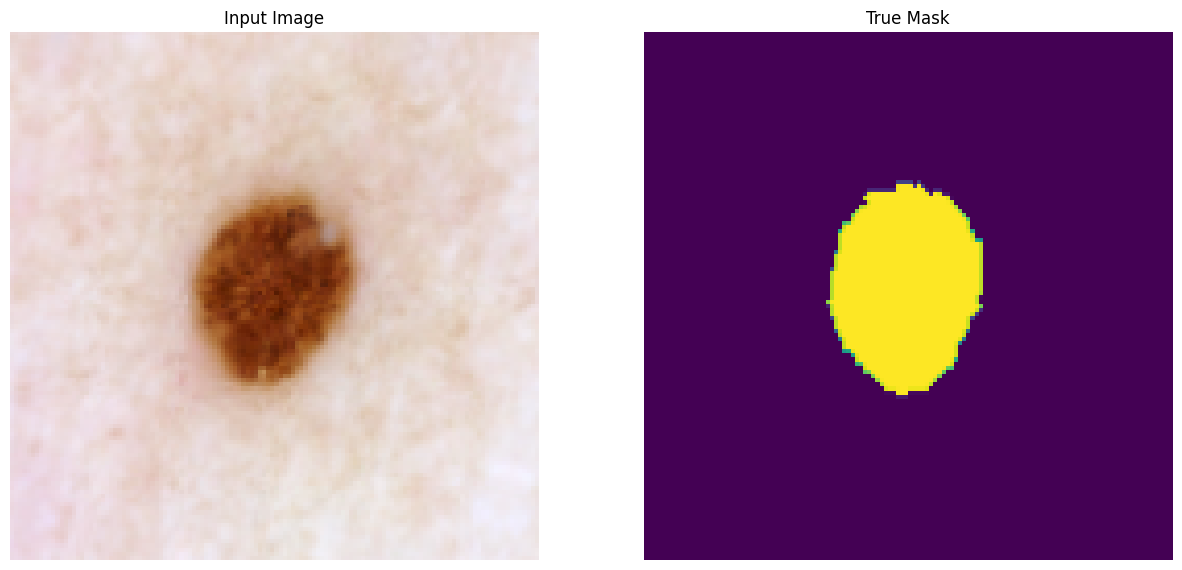

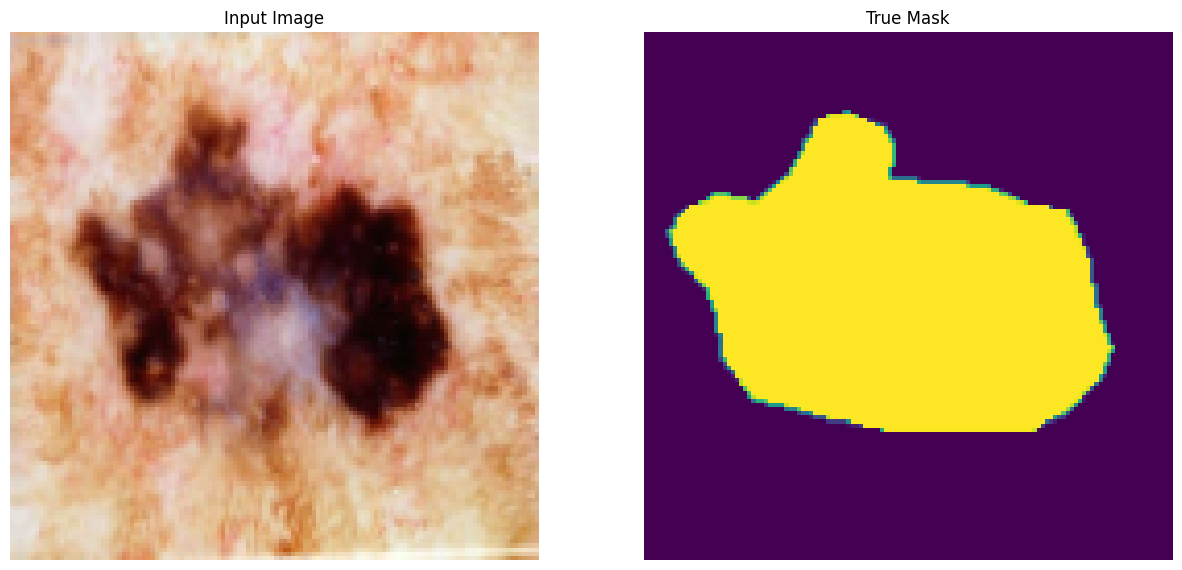

In [28]:
for image,masks in train_batches.take(2):
  sample_image,sample_mask =image[0],masks[0]
  display([sample_image,sample_mask])

In [29]:
base_model=tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layer_names=[
    'block_1_expand_relu', # 4096
    'block_3_expand_relu', #1024
    'block_6_expand_relu', #256
    'block_13_expand_relu', #64
    'block_16_project',  #16
]

base_model_outputs=[base_model.get_layer(name).output for name in layer_names]

down_stack=tf.keras.Model(inputs=base_model.input,outputs=base_model_outputs)

down_stack.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
inputs=tf.keras.layers.Input(shape=[128,128,3])

skips=down_stack(inputs)
x=skips[-1]
skips=reversed(skips[:-1])
print(x)

c1,p1=encoder_block(inputs,n_filters=64)
print(f"c1 : {c1} et p1 : {p1}")

<KerasTensor shape=(None, 4, 4, 320), dtype=float32, sparse=False, name=keras_tensor_186>


NameError: name 'encoder_block' is not defined

In [43]:

def conv_block(x,n_filters):
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  print("X ...",x)
  return x

def decoder_block(x,p,n_filters):
  x=Conv2DTranspose(n_filters,(2,2),strides=(2,2),padding='same')(x)
  print(f"X :{x} and P :{p}")
  x=concatenate([x,p])
  x=conv_block(x,n_filters)
  return x

#up_stack
class UP_STACK():
  def __init__(self,bridge,p1,p2,p3,p4):
    #bridge=conv_block(p4,n_filters=1024)
    self.u4=decoder_block(bridge,p4,n_filters=512)
    self.u3=decoder_block(self.u4,p3,n_filters=256)
    self. u2=decoder_block(self.u3,p2,n_filters=128)
    self.u1=decoder_block(self.u2,p1,n_filters=64)


inputs=tf.keras.layers.Input(shape=[128,128,3])

skips=down_stack(inputs)
p1=skips[0]
p2=skips[1]
p3=skips[-3]
p4=skips[-2]
bridge=skips[-1]
print(f"P1 :{p1} P2 :{p2} P3 :{p3} P4 :{p4}")
up_stack=UP_STACK(bridge,p1,p2,p3,p4)
#p4=skips[-1]
print("U1 ",up_stack.u1)
outputs=Conv2DTranspose(filters=2,kernel_size=(1,1),strides=(2,2),activation='softmax')(up_stack.u1)

#filters ==> n_classes (numbers of  caracteristics card (=number of classes))
"""
last_layer=tf.keras.layers.Conv2DTranspose(
    filters=output_channels,kernel_size=3,strides=3
)"""
model=Model(inputs=[inputs],outputs=[outputs])

P1 :<KerasTensor shape=(None, 64, 64, 96), dtype=float32, sparse=False, name=keras_tensor_220> P2 :<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, name=keras_tensor_221> P3 :<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_222> P4 :<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_223>
X :<KerasTensor shape=(None, 8, 8, 512), dtype=float32, sparse=False, name=keras_tensor_225> and P :<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_223>
X ... <KerasTensor shape=(None, 8, 8, 512), dtype=float32, sparse=False, name=keras_tensor_228>
X :<KerasTensor shape=(None, 16, 16, 256), dtype=float32, sparse=False, name=keras_tensor_229> and P :<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_222>
X ... <KerasTensor shape=(None, 16, 16, 256), dtype=float32, sparse=False, name=keras_tensor_232>
X :<KerasTensor shape=(None, 32, 32, 128)

In [21]:
for skip in skips:
  print(skip)

<KerasTensor shape=(None, 64, 64, 96), dtype=float32, sparse=False, name=keras_tensor_170>
<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, name=keras_tensor_171>
<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_172>
<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_173>
<KerasTensor shape=(None, 4, 4, 320), dtype=float32, sparse=False, name=keras_tensor_174>


In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              )

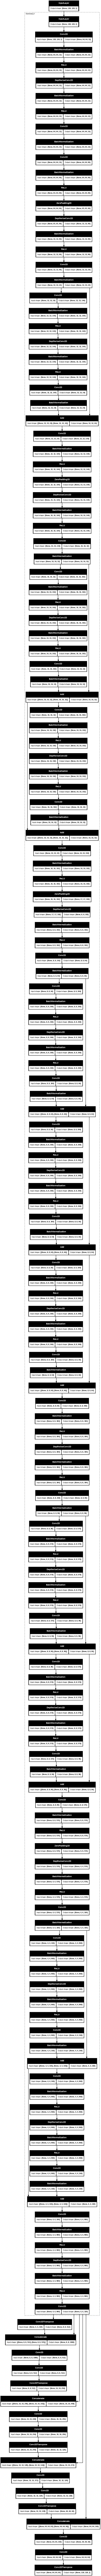

In [46]:
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=True,dpi=64)

In [47]:
def create_mask(pred_mask):
  pred_mask=tf.math.argmax(pred_mask,axis=-1)
  pred_mask=pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [48]:
def show_predictions(dataset=None,num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask=model.predict(image)
      display([image[0],mask[0],create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis,...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


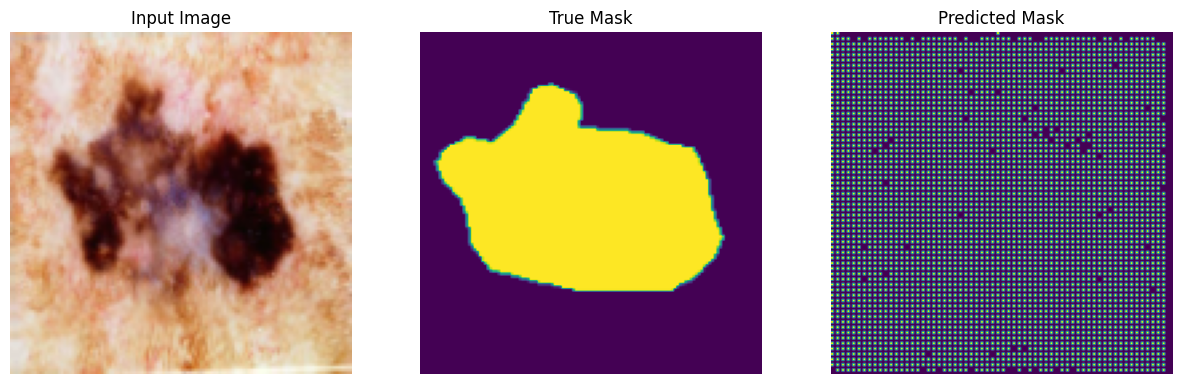

In [49]:
show_predictions()

In [ ]:
class DisplayCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(seelf,epoch,logs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSample Prediction after epoch {}\n".format(epoch+1))

In [32]:
len(train_dataset)//BATCH_SIZE

40

In [50]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_6 (Functional) │ [(None, 64, 64, 96),   │      1,841,984 │ input_layer_11[0][0]   │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576),     │                │                        │
│                           │ (None, 4, 4, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 8, 8, 512)      │        655,872 │ functional_6[2][4]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 8, 8, 1088)     │              0 │ conv2d_transpose_5[0]… │
│ (Concatenate)             │                        │                │ functional_6[2][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      5,014,016 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 16, 16, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 16, 16, 448)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ functional_6[2][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 256)    │      1,032,448 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 32, 32, 128)    │        131,200 │ conv2d_11[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 32, 32, 272)    │              0 │ conv2d_transpose_7[0]… │
│ (Concatenate)             │                        │                │ functional_6[2][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 128)    │        313,472 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_12[0][0]        │
├──────────────────────

 Total params: 12,773,122 (48.73 MB)

 Trainable params: 10,931,138 (41.70 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [52]:
len(val_subset)

16

In [53]:
print("First batch of val_batches:", next(iter(val_batches)))

StopIteration: 

In [51]:
from keras import callbacks
EPOCHS=20
VAL_SUBSPLITS=5
STEPS_PER_EPOCH=train_size//BATCH_SIZE
VALIDATION_STEPS=valid_size//BATCH_SIZE//VAL_SUBSPLITS

earlystopping=callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=5,
                                       restore_best_weights=True)
print("STEPS_PER_EPOCH :",STEPS_PER_EPOCH)
print("VALIDATION_STEPS :",VALIDATION_STEPS)
print("callbacks", earlystopping)
model_history=model.fit(train_batches,
                        epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=VALIDATION_STEPS,
                        validation_data=val_batches,
                        callbacks=[earlystopping],
                        verbose=1
                        )

STEPS_PER_EPOCH : 28
VALIDATION_STEPS : 1
callbacks <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7e4a887f3010>
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7321 - loss: 0.6944

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

In [43]:
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [33]:
for batch in train_batches.take(1):
    print(batch)

(<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
array([[[[6.5836906e-01, 6.1915338e-01, 6.2053800e-01],
         [6.5874988e-01, 6.2165976e-01, 6.2564135e-01],
         [6.6221333e-01, 6.3396835e-01, 6.4760959e-01],
         ...,
         [6.1947477e-01, 5.7207179e-01, 5.4427660e-01],
         [6.1182493e-01, 5.5891830e-01, 5.2268219e-01],
         [6.0937703e-01, 5.5457515e-01, 5.1559889e-01]],

        [[6.5961498e-01, 6.2175220e-01, 6.2419367e-01],
         [6.6004837e-01, 6.2431693e-01, 6.2925279e-01],
         [6.6362023e-01, 6.3642859e-01, 6.5052664e-01],
         ...,
         [6.1858451e-01, 5.6964457e-01, 5.4230082e-01],
         [6.0905403e-01, 5.5514163e-01, 5.1711732e-01],
         [6.0610658e-01, 5.5052459e-01, 5.0938654e-01]],

        [[6.6174757e-01, 6.3082558e-01, 6.3919312e-01],
         [6.6318941e-01, 6.3391882e-01, 6.4392126e-01],
         [6.6969883e-01, 6.4616948e-01, 6.6185570e-01],
         ...,
         [6.1608607e-01, 5.6111145e-01, 5.3549069e-01]

In [ ]:
loss=model_history['loss']
val_loss=model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch,loss,'r',label='Training loss')
plt.plot(model_history.epoch,val_loss,'bo',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
def unet_model(output_chanels:int):
  inputs=tf.keras.layers.Input(shape=[128,128,3])

  skips=down_stack(inputs)
  x=skips[-1]
  skips=reversed(skips[:-1])

  for up ,skip in zin(upstack,skips):
    x=up(x)
    concat=tf.keras.layers.Concatenate()
    x =concat([x,skip])

  last=tf.keras.layers.Conv2DTranspose(
      filters=output_channels,kernel_size=3,strides=2,
      padding='same')
  x=last(x)
  return tf.keras.Model(inputs=inpputs,outputs=x)

In [47]:
from tensorflow.keras.layers import Input,Conv2D ,MaxPooling2D,concatenate,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Model

def conv_block(x,n_filters):
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  return x


def encoder_block(x,n_filte rs):
  x=conv_block(x,n_filters)
  p=MaxPooling2D((2,2))(x)
  return x, p

def decoder_block(x,p,n_filters):
  x=Conv2DTranspose(n_filters,(2,2),strides=(2,2),padding='same')(x)
  x=concatenate([x,p])
  x=conv_block(x,n_filters)
  return x

def unet_model(n_classes,img_height,img_width,img_channels):
  inputs=Input((img_height,img_width,img_channels))

  #Contraction path,encoder
  c1,p1=encoder_block(inputs,n_filters=64)
  c2,p2=encoder_block(c1,n_filters=128)
  c3,p3=encoder_block(c2,n_filters=256)
  c4,p4=encoder_block(c3,n_filters=512)
  print("P4... :",p4)
  #Bottleneck
  bridge=conv_block(p4,n_filters=1024)

  #Expansive path,decoder
  u4=decoder_block(bridge,p4,n_filters=512)
  u3=decoder_block(u4,p3,n_filters=256)
  u2=decoder_block(u3,p2,n_filters=128)
  u1=decoder_block(u2,p1,n_filters=64)

  outputs=Conv2D(n_classes,(1,1),activation='softmax')(u1)
  model=Model(inputs=[inputs],outputs=[outputs])
  return model
"""
unet_model=multi_unet_model(
    n_classes=5,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    img_channels=3
)"""




'\nunet_model=multi_unet_model(\n    n_classes=5,\n    img_height=IMG_HEIGHT,\n    img_width=IMG_WIDTH,\n    img_channels=3\n)'

In [49]:
unet_model(4,128,128,3)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 512), (None, 64, 64, 512)]